# About VinBigData Chest X-ray Abnormalities

> In this competition, you’ll automatically localize and classify 14 types of thoracic abnormalities from chest radiographs. You'll work with a dataset consisting of 18,000 scans that have been annotated by experienced radiologists. You can train your model with 15,000 independently-labeled images and will be evaluated on a test set of 3,000 images. These annotations were collected via VinBigData's web-based platform, VinLab. Details on building the dataset can be found in our recent paper “VinDr-CXR: An open dataset of chest X-rays with radiologist's annotations”.

![](https://i.imgur.com/QWmbhXx.png)

# 1. Dicom to Numpy array

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import pydicom
from glob import glob
from tqdm.notebook import tqdm
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt
from skimage import exposure
import cv2
import warnings
warnings.filterwarnings('ignore')

All images in dataset are DICOM format. So we need to convert data from DICOM to numpy array. Original dicom2array function in [raddar's notebook](https://www.kaggle.com/raddar/convert-dicom-to-np-array-the-correct-way)

In [2]:
dataset_dir = '../input/vinbigdata-chest-xray-abnormalities-detection'

In [3]:

def dicom2array(path, voi_lut=True, fix_monochrome=True):
    dicom = pydicom.read_file(path)
    # VOI LUT (if available by DICOM device) is used to
    # transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data
        
    
def plot_img(img, size=(7, 7), is_rgb=True, title="", cmap='gray'):
    plt.figure(figsize=size)
    plt.imshow(img, cmap=cmap)
    #plt.suptitle(title)
    plt.show()


def plot_imgs(imgs, cols=4, size=7, is_rgb=True, title="", cmap='gray', img_size=(500,500)):
    rows = len(imgs)//cols + 1
    fig = plt.figure(figsize=(cols*size, rows*size))
    for i, img in enumerate(imgs):
        if img_size is not None:
            img = cv2.resize(img, img_size)
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(img, cmap=cmap)
    #plt.suptitle(title)
    plt.show()
    
# def draw_bboxes(img, boxes, thickness=10, color=(255, 0, 0), img_size=(500,500)):
#     img_copy = img.copy()
#     if len(img_copy.shape) == 2:
#         img_copy = np.stack([img_copy, img_copy, img_copy], axis=-1)
#     for box in boxes:
#         img_copy = cv2.rectangle(
#             img_copy,
#             (int(box[0]), int(box[1])),
#             (int(box[2]), int(box[3])),
#             color, thickness)
#     if img_size is not None:
#         img_copy = cv2.resize(img_copy, img_size)
#     return img_copy

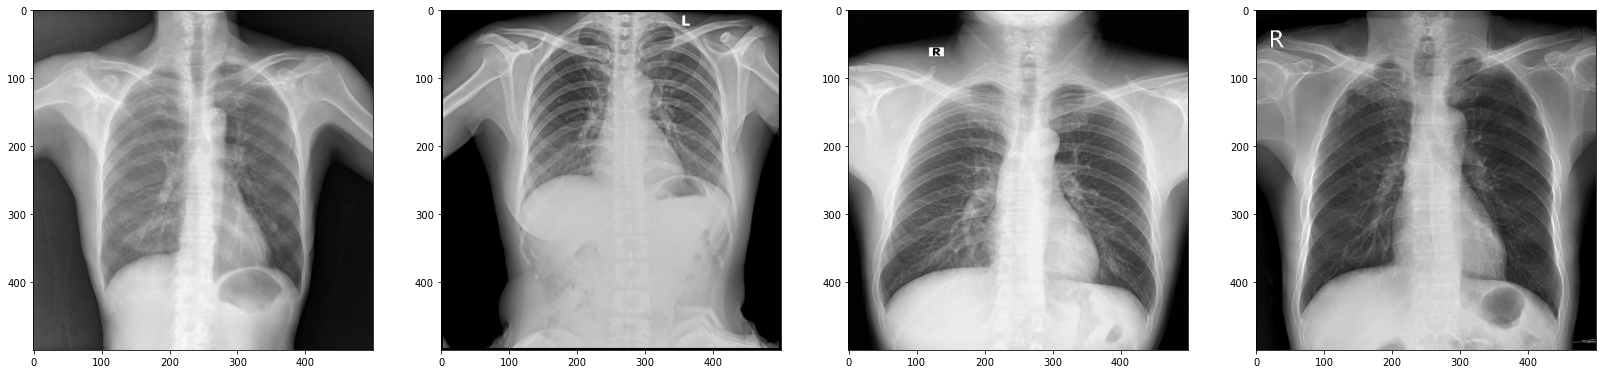

In [4]:
dicom_paths = glob(f'{dataset_dir}/train/*.dicom')
imgs = [dicom2array(path) for path in dicom_paths[:4]]
plot_imgs(imgs)

Maybe, you can try some preprocess like equalize histogram. You can see the difference between before and after

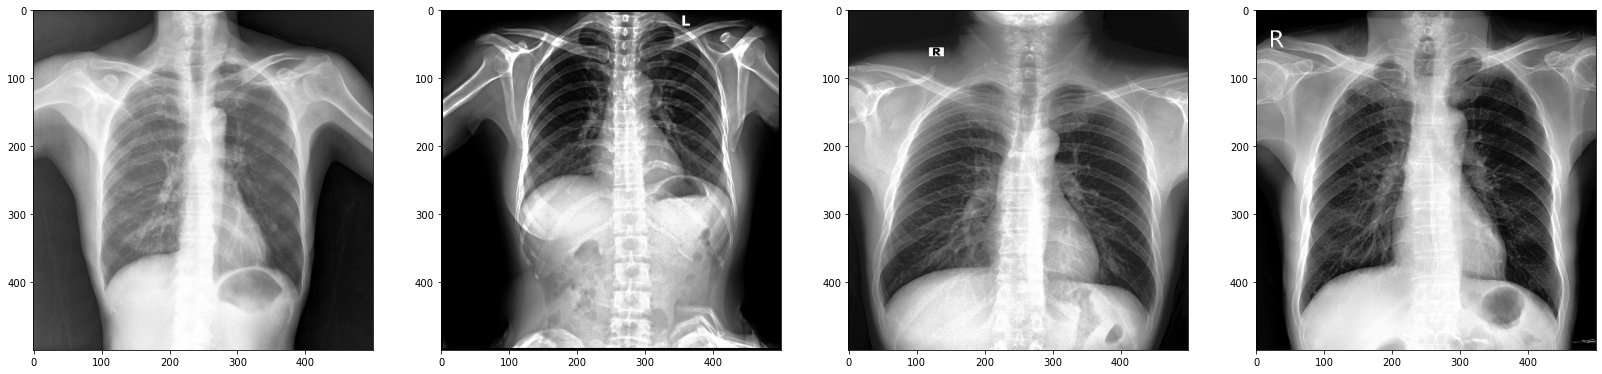

In [5]:

imgs = [exposure.equalize_hist(img) for img in imgs]
plot_imgs(imgs)


# 2. EDA csv

### Now, we will try some EDA steps to find out important features in this data set

In [6]:
from bokeh.plotting import figure as bokeh_figure
from bokeh.io import output_notebook, show, output_file
from bokeh.models import ColumnDataSource, HoverTool, Panel
from bokeh.models.widgets import Tabs
import pandas as pd
from PIL import Image
from sklearn import preprocessing
import random
from random import randint




In [7]:
def get_bbox_area(row):
    return (row['x_max']-row['x_min'])*(row['y_max']-row['y_min'])

train_df = pd.read_csv(f'{dataset_dir}/train.csv')
#train_df.head()
le = preprocessing.LabelEncoder()  # encode rad_id
#print(le)
train_df.rad_id.value_counts()


R9     15708
R10    13292
R8     12198
R2      3121
R5      2783
R3      2285
R6      2041
R1      1995
R13     1824
R15     1823
R16     1763
R7      1733
R12     1729
R11     1670
R14     1624
R4      1513
R17      812
Name: rad_id, dtype: int64

In [8]:
train_df['rad_label'] = le.fit_transform(train_df['rad_id'])
train_df.head()

finding_df = train_df[train_df['class_name'] != 'No finding']
finding_df['bbox_area'] = finding_df.apply(get_bbox_area, axis=1)
finding_df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,rad_label,bbox_area
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,1,438672.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,1,95772.0
5,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,627.0,357.0,947.0,433.0,16,24320.0
6,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,1347.0,245.0,2188.0,2169.0,8,1618084.0
7,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,557.0,2352.0,675.0,2484.0,16,15576.0


## 2.1 Plot bounding box

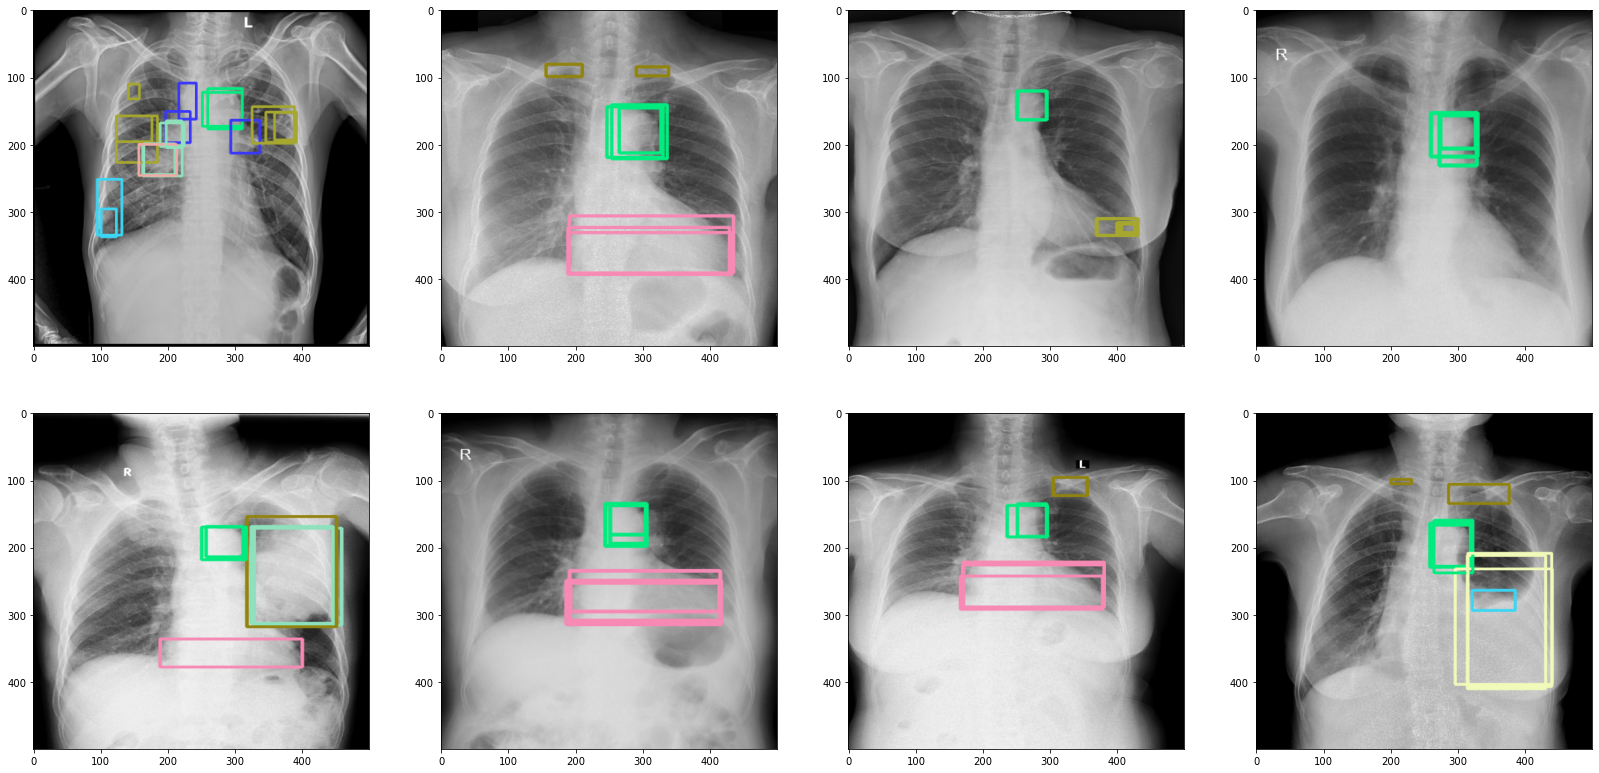

In [9]:
imgs = []
img_ids = finding_df['image_id'].values
class_ids = finding_df['class_id'].unique()

# map label_id to specify color
label2color = {class_id:[randint(0,255) for i in range(3)] for class_id in class_ids}
thickness = 3
scale = 5


for i in range(8):
    img_id = random.choice(img_ids)
    img_path = f'{dataset_dir}/train/{img_id}.dicom'
    img = dicom2array(path=img_path)
    img = cv2.resize(img, None, fx=1/scale, fy=1/scale)
    img = np.stack([img, img, img], axis=-1)
    
    boxes = finding_df.loc[finding_df['image_id'] == img_id, ['x_min', 'y_min', 'x_max', 'y_max']].values/scale
    labels = finding_df.loc[finding_df['image_id'] == img_id, ['class_id']].values.squeeze()
    
    for label_id, box in zip(labels, boxes):
        color = label2color[label_id]
        img = cv2.rectangle(
            img,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, thickness
    )
    img = cv2.resize(img, (500,500))
    imgs.append(img)
    
plot_imgs(imgs, cmap=None)

You can see that: in each image, there are many overlapping boxes. Note that a key part of this competition is working with ground truth from multiple radiologists. I guess it is a key to get best rank in this competition if you handle it skillfully.

## 2.2 Plot histogram

We will try to plot some histograms.  The hist_hover function allows you to interact very well with chart

In [10]:
def hist_hover(dataframe, column, color=["#94c8d8", "#ea5e51"], bins=30, title="", value_range=None):
    """
    Plot histogram
    """
    hist, edges = np.histogram(dataframe[column], bins=bins, range=value_range)
    hist_frame = pd.DataFrame({
        column: hist,
        "left": edges[:-1],
        "right": edges[1:]
    })
    hist_frame["interval"] = ["%d to %d" %
                              (left, right) for left, right in zip(edges[:-1], edges[1:])]
    src = ColumnDataSource(hist_frame)
    plot = bokeh_figure(
        plot_height=400, plot_width=600,
        title=title, x_axis_label=column,
        y_axis_label="Count"
    )
    plot.quad(
        bottom=0, top=column, left="left", right="right",
        source=src, fill_color=color[0], line_color="#35838d",
        fill_alpha=0.7, hover_fill_alpha=0.7,
        hover_fill_color=color[1]
    )
    hover = HoverTool(
        tooltips=[("Interval", "@interval"), ("Count", str(f"@{column}"))]
    )
    plot.add_tools(hover)
    output_notebook()
    show(plot)
    
    
hist_hover(train_df, column='class_id')

Loading BokehJS ...

you can see the imbalance between image qualtity of each class

In [11]:
#Note that a key part of this competition is working with ground truth from multiple radiologists.
hist_hover(train_df, column='rad_label')

Loading BokehJS ...

The imbalance between image qualtity of each radiologist

In [12]:
## histogram of bbox area
hist_hover(finding_df, column='bbox_area')

Loading BokehJS ...

After some EDA steps, we recognize that the dataset fairly imbalance in many aspects. Maybe, we need to use some augmentation method to resolve the problem.


# 3. Don't forget to upvote :D